## Set up drive storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os 

%cd /content/drive/MyDrive

if not os.path.exists("ViT2MLP"):
  os.mkdir("ViT2MLP")

%cd ViT2MLP

## Code for transformer

References:
- [main transformer docs](https:huggingface.co/docs/transformers/index) 
- [ViT Docs](https://huggingface.co/docs/transformers/model_doc/vit)
- [lighting finetuning example](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer)

In [ ]:
!pip install -q transformers datasets[vision] pytorch-lightning

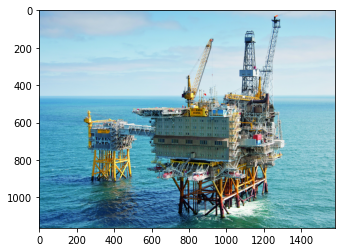

In [ ]:
import matplotlib.pyplot as plt

image = plt.imread("a.jpg")[:,:,:3]
plt.imshow(image)

### Example of transformer model

Load ViT finetuned on Imnet1k. To load the non fine-tuned version use **"google/vit-base-patch16-224-im21k"**

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():

    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes

predicted_label = logits.argmax(-1).item()


print(model.config.id2label[predicted_label])

540
drilling platform, offshore rig


## Code for MLP mixer

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 477 kB/s 


In [ ]:
#tentative pytorch implementation for https://github.com/google-research/vision_transformer/blob/main/vit_jax/models_mixer.py
#to include: apache license lol

from typing import Any, Optional
import numpy as np
import einops
import torch.nn as nn
import torch.nn.functional as F


class MlpBlock(nn.Module):

  #TODO: implement with sequential
  def __init__(self, mlp_dim):
    super().__init__()
    #dense implementation only has out features specified, need to check input dim
    self.mlp1 = nn.Linear(in_features=mlp_dim, out_features = mlp_dim)
    self.mlp2 = nn.Linear(in_features=mlp_dim, out_features = mlp_dim)
    self.activation = F.gelu

  def forward(self, x):
    y = self.mlp1(x)
    y = self.activation(y)
    y = self.mlp2(y)
    return y

class MixerBlock(nn.Module):

  #TODO:??
  def __init__(self, tokens_mlp_dim, channels_mlp_dim):
    super().__init__()
    self.layer_norm = F.layer_norm
    self.mlpblock_token_mixer = MlpBlock(tokens_mlp_dim)
    self.mlpblock_channel_mixer = MlpBlock(channels_mlp_dim)

  def forward(self,x):
    y = self.layer_norm(x)
    y = np.swapaxes(y,1,2)
    y = self.mlpblock_token_mixer(y)
    y = np.swapaxes(y,1,2)
    x = x + y
    y = self.layer_norm(x)
    return x + self.mlpblock_channel_mixer(y)

class MlpMixer(nn.Module):
  """Mixer architecture"""

  def __init__(self, hidden_dim : int, patches : Any,
               num_blocks: int, tokens_mlp_dim : int,
               channels_mlp_dim : int, num_classes: int):
    self.hidden_dim = hidden_dim
    self.patches = patches
    self.num_blocks = num_blocks
    self.num_classes = num_classes
    #per patch fully connected?
    self.stem = nn.Conv2d(in_channels = self.hidden_dim, out_channels = self.patches.size,
                  stride = self.patches.size)
    self.mixer_block = MixerBlock(self.tokens_mlp_dim, self.channels_mlp_dim)
    self.layer_norm = F.layer_norm
    #What is kernel init? Does it initialize everything to 0?
    self.fc = nn.Linear(input_features = self.channels_mlp_dim, output_features = self.num_classes)

  #what is * ?
  def forward(self, inputs, *, train):
    #why delete train?
    del train
    x = self.stem(x)
    x = einops.rearrange(x, 'n h w c -> n (h w) c')
    for _ in range(self.num_blocks):
      x = self.mixer_block(x)
    x = self.layer_norm(x)
    x = np.mean(x, axis = 1)
    if self.num_classes:
      #add classification layer if num classes is specified
      x = self.fc(x)
    return x